# Demo: Automatically Stopping MH via a Batch Means Approach

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
# Update 07/18/22: got retina working with updates thanks to 
# https://stackoverflow.com/questions/54312924/what-is-matplotlibs-retina-display-mode
%matplotlib inline
%config InlineBackend.figure_format='retina'

In this demo we finally turn to the question of how we can make a MCMC algorithm automatically decide whether or not the sample it has generated is "large enough". In all pervious demos, we've just chosen a sample size and rolled the dice, hoping to get a reasonable histogram: this is obviously not really a practical way to perform sampling in general. Our approach is based on the notion of **batch means**, and for simplicity we'll just use vanilla MH and sample a univariate Gaussian. 

A fair warning: this demo will be even more lean on theory than usual!  

## Suggested References
- Jones et al., "Fixed-Width Output Analysis for Markov Chain Monte Carlo", J. ASA, 2006 https://doi.org/10.1198/016214506000000492 

- Roger Peng's lecture notes, https://bookdown.org/rdpeng/advstatcomp/metropolis-hastings.html

## Abusing the Central Limit Theorem to Guide Sampling

Let $\Omega\subseteq \mathbb{R}^{N}$ and let $f(x)$ be a probability distribution on $\Omega$. Suppose we are interested in sampling $f(x)$ to approximate the expectation of a random variable $g\colon \Omega\rightarrow \mathbb{R}$
$$
\langle g \rangle = \int_{\Omega} g(x) \ f(x) \ \mathrm{d} x. 
$$
Call our samples $X_{1}, ...., X_{n}$, and denote the approximate average with $n$ samples by 
$$
\langle g\rangle_{n} = \frac{1}{n}\sum_{j=1}^{n}g\left(X_{j}\right). 
$$

Now, what can we say about the error 
$$
\text{error} = \langle g\rangle_{n} - \langle g\rangle ? 
$$
An irresponsible application of the central limit theorem tells us exists a real number $\sigma_{\infty}\in (0,\infty)$ such that
$$
    \sqrt{n} \ \left(\langle g\rangle_{n} - \langle g\rangle\right) \rightarrow \mathcal{N}\left(0,\sigma_{\infty}^2\right),
$$
where the convergence is understood to mean "convergence in distribution". Loosely, this means that for $n\gg 1$ we have approximately that
$$
\langle g\rangle_{n} - \langle g\rangle \sim \mathcal{N}\left(0,\left(\frac{\sigma_{\infty}}{\sqrt{n}}\right)^2\right)
$$
where we have used the scaling properties of Gaussian random variables. Using the confidence interval heuristic for the normal distribution, after taking many samples we can be about $95\%$ sure that 
$$
\left|\langle g\rangle_{n} - \langle g\rangle\right|\leq 2\frac{\sigma_{\infty}}{\sqrt{n}}.
$$
So, we can very loosely estimate the maximum error in our Monte Carlo approximation of $\langle g\rangle$ provided we can estimate $\sigma_{\infty}$. Assume for the moment that we have a good sequence of approximations
$$
\sigma_{n} \approx \sigma_{\infty};
$$
we'll describe below one way of obtaining such an approximating sequence. We then know that 
$$
2\frac{\sigma_{n}}{\sqrt{n}}
$$
is an upper bound for our approximation error, at least with high probability. If we fix an error tolerance $\epsilon\ll 1$ then we can be reasonably confident that, if $n$ is such that 
$$
\frac{\sigma_{n}}{\sqrt{n}} < \frac{\epsilon}{2},
$$
then 
$$
\left|\langle g\rangle_{n} - \langle g\rangle\right| < \epsilon.
$$
Assuming we are perfectly fine with accuracy $\epsilon$, we can stop our sampling at step $n$ and get an acceptable estimate! Thus, an abuse of the central limit theorem has given us a general criterion for stopping our MCMC algorithm, provided we can estimate the limiting standard deviation $\sigma_{\infty}$ of our errors in the mean of $g$.

Note that this whole convergence paradigm is focused on us choosing a particular random variable $g(x)$ as special! 

## Estimating $\sigma_{\infty}$ via Batch Means

We can easily generate a sequence $\sigma_{n}$ approximating $\sigma_{\infty}$ using **batch means**; this is a method advocated in Jones et al., and I recommend the reader look at this paper for some actual theoretical justication of the batch means approach. 

Assume we are willing to run our MCMC algorithm for a maximum of $N$ steps. To approximate $\sigma_{\infty}$, suppose we are at step $n\leq N$ of the Markov chain iteration, so we have $n$ samples $X_{1}, ..., X_{n}$. We partition our samples into $M$ batches of size $K$ (so in particular $n=KM$... note that we can in principle have $M=M(n)$ and $K=K(n)$), then form the so-called batch means 
$$
b_{\ell} = \frac{1}{K}\sum_{j=\ell K}^{\left(\ell+1\right)K} g\left(X_{j}\right), \quad \ell=0,1,...,M-1.
$$
Notice that 
$$
\langle g\rangle_{n} = \frac{1}{M}\sum_{\ell=0}^{M-1} b_{\ell},
$$
so our guess at the expectation of $g$ is nothing but the mean of the batch means. 

With our batch means at hand, define 
$$
\sigma_{n} = \left[K\text{Var}\left(b_0, ..., b_{M-1}\right)\right]^{\frac12}
 = \left[\frac{1}{n}\sum_{\ell=0}^{M-1}\left(b_{\ell}-\langle g\rangle_{n}\right)\right]^{\frac12}. 
$$
We can then use this $\sigma_{n}$ to check convergence, as outlined above. In this demo, I shall make no attempts to justify why this choice of $\sigma_{n}$ can possibly work! However, when we get to some simple numerical experiments below, we'll find empirically that it actually does give us a pretty solid error estimate. 

## Code Example 1: Automatically Stopping MH Sampling of a Univariate Normal Distribution with Fixed Batch Size

We now show how to use the above stopping framework to control the convergence of MH when sampling the normal distribution with mean $0$ and standard deviation $\sigma$, 
$$
f(x) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac12\left(\frac{x}{\sigma}\right)^2\right). 
$$
For starters, we use a fixed batch size $K$ depending only on the maximum number of iterations $N$ we are allowed. Of course, we then have $M = M(n) = \lfloor n/K\rfloor$. For our "special" random variable $g$, we simply take $g(x)=x$. Thus the expectation of $g$ we are trying to approximate is simply the mean of $f$, namely $0$. 

First, we define our distribution up to normalization for checking acceptability of an MH step. 

In [2]:
sigma = 1. # standard deviation of our distribution

def f(x): # un-normalized normal distribution with std dev sigma
    return np.exp((-0.5/sigma**2)*x**2)

Now, we globally set the convergence tolerance for our code examples: we stop the iteration when our error guess is below the tolerance $\texttt{tol}$. 

In [3]:
tol = 5e-2

Strictly speaking, we don't quite use the same convergence criterion outlined above. Instead, we stop the iterations when the step number $n$ is such that 
$$
\frac{\sigma_{n}}{\sqrt{n}} + \Lambda(n) < \texttt{tol},
$$
where $\Lambda(n)$ is a penalty function that prevents the routine from accidentally converging too early. Here, we take $\Lambda(n) = \text{constant}* n^{-1}$, so it decays faster than the first term. Notice that, if we ignore $\Lambda(n)$ for the time being, this stopping criterion only gives us about $65\%$ confidence in our error being less than $\texttt{tol}$, but I have found this is prefectly OK. 

Now, we re-implement our Gaussian sampling routine with the added feature of automatic stopping. 

In [4]:
def mh_gaussian_sampling(x0, params = [2e-1,int(1e2), int(1e1)]):
# x0 = initial guess

# the array "params" includes 

# h = maximum step size

# N = maximum number of samples (default to 5e4 or something)

# K = batch size (default to 10 or 100 or something, approx. sqrt(t))

    h = params[0]
    
    N = params[1]
    
    K = params[2]

    x = np.zeros(N, dtype = 'float') # vector storing samples 
    
    batch_means  = np.array([]) # initialize batch means as empty, then add to it every K steps
    
    # use initial guess
    x[0]= x0
    
    # initialize rejection counter
    rejected = 0. 
    
    # set timer
    start = time.time()
    
    t = 0 # counter of iterations
    
    converged = False # convergence flag

    while converged == False:
        # randomly select step size
        increment = np.random.uniform(low=-h,high=h) 
        
        # note: the above seems to work a lot better than using a "true" (2-state Bernoulli)
        # random walk with fixed step size! 
    
        # tentative next guess
        y = x[t-1] + increment
    
        alpha = f(y)/f(x[t-1])
    
        u = np.random.uniform(low=0., high=1.)

        if u <= alpha:
        
            x[t] = y
                    
        elif u > alpha:
    
            x[t] = x[t-1]
        
            rejected += 1
            
        # now enter convergence check every K steps after a sufficiently long time        
        if t % K == 0 and t > 1:  
        
            # get number of batches 
            M = int(t/K)
                                
            # add current batch mean to list of batch means 
            batch_means = np.append(batch_means, np.mean(x[(M-1)*K:t]))
            
            # finally, test convergence 
            sd_guess = np.sqrt(K*np.var(batch_means))
            
            #print('batch_means =', batch_means)
            #print('sigmasq_guess =', sigmasq_guess)
            
            if sd_guess*t**-0.5 + 0.5*t**-1 < tol and M > 1: 
                
                converged = True 
                
                print('Chain converged') 
            
            else: 
                
                pass
        
        # also allow convergence if maximum number of iterations reached 
        if t == N-1: 
                
            converged = True 
            
            print('Chain terminated, max. number of iterations reached') 
            
        else: 
                
            pass
        
        # finally, update timer and end the current step
        t += 1
    
    rej_ratio =  rejected/t
            
    print('Rejection Ratio = %.4f' % rej_ratio) 
    
    end = time.time()
    
    runtime  = end - start
    
    print('Runtime = %.2f' % runtime, 'seconds')
        
    print('Number of Iterations = ', t)
    
    print('Final sd_guess = %.4f' % sd_guess)
            
    return x[:t], sd_guess

We now take a sample and plot its histogram. 

In [16]:
h = 1e0

N = int(1e4)

K = int(N**0.5)

params = [h, N, K]

x, sd_guess = mh_gaussian_sampling(0., params)

Chain converged
Rejection Ratio = 0.1911
Runtime = 0.12 seconds
Number of Iterations =  6001
Final sd_guess = 3.8574


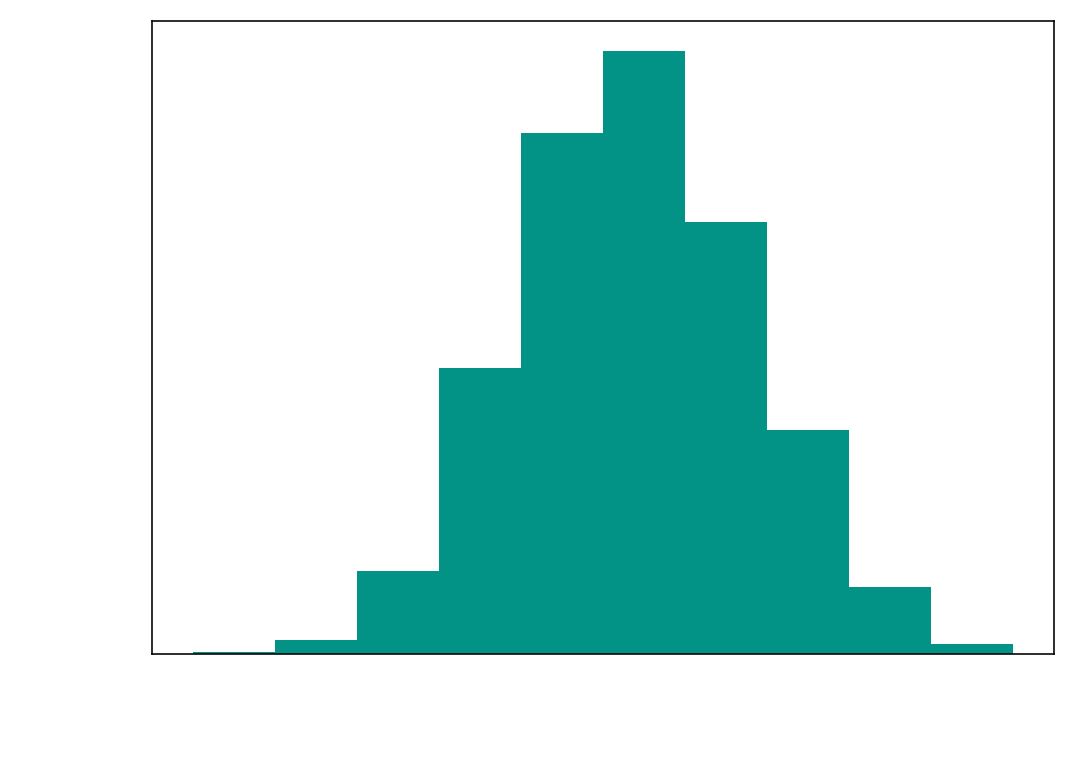

In [17]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

plt.hist(x, color='xkcd:teal')

plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.xlabel(r"Position $x$", fontsize=30, color = 'w')
plt.ylabel(r"Number of Samples", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600

#"""
plt.show()

Typically I find it takes a few thousand iterations to converge, and the histogram we get ends up looking pretty nice. 

We can also asses how our approximate means $\langle x \rangle_{n}$ approximate the true mean $0$. Our earlier heuristics tell us that the error in approximation at step $n$ is approximately normally distributed with standard deviation 
$$
\frac{\sigma_{n}}{\sqrt{n}}. 
$$
Accordingly, while plotting the sequence of $\langle x\rangle_{n}$'s we also plot the sequence 
$$
\frac{\sigma_{n_{0}}}{\sqrt{n}},
$$
where $n_0$ is the iteration we stopped at. 

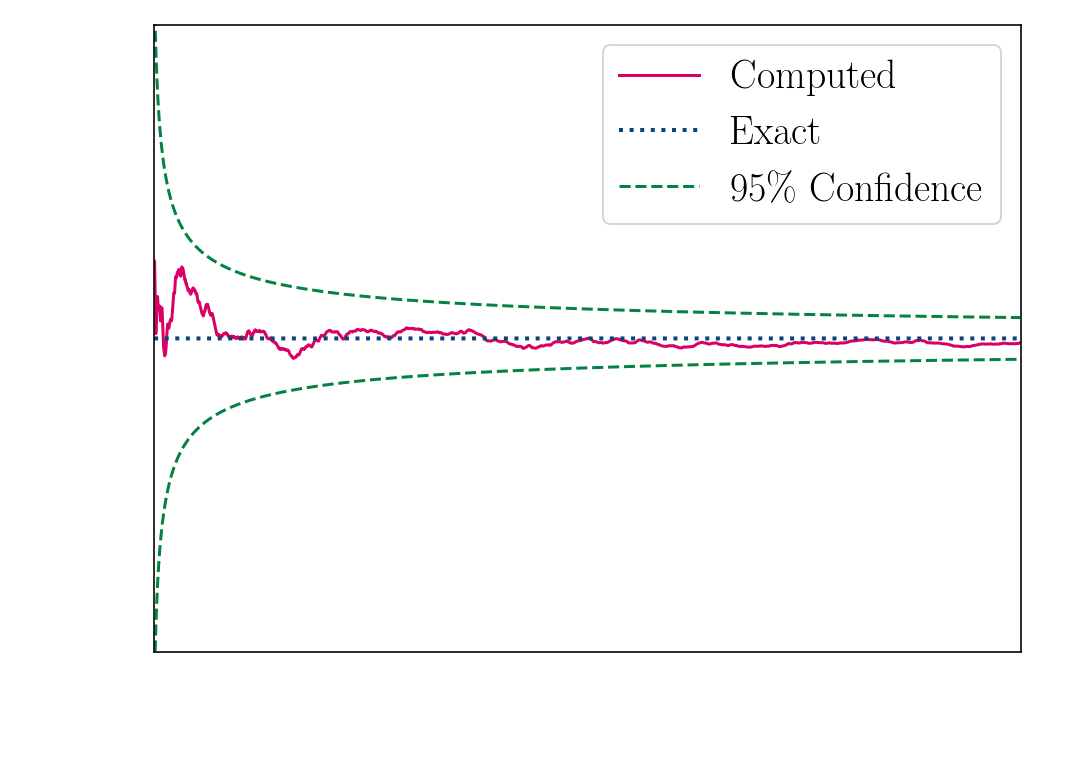

In [18]:
means = np.zeros_like(x)[1:]

Q = np.shape(means)[0]

for k in np.arange(1, Q):
    
    means[k] = np.mean(x[0:k])

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

NN = np.arange(0,Q)

plt.plot(NN, means, linewidth = 1.5, color='xkcd:dark hot pink')
plt.plot(NN, np.zeros(Q), linewidth = 2, color='xkcd:twilight blue', linestyle='dotted')
plt.plot(NN[20:], 2.*sd_guess*NN[20:]**-0.5, linewidth = 1.5, color='xkcd:jungle green', linestyle='dashed')
plt.plot(NN[20:],-2.*sd_guess*NN[20:]**-0.5, linewidth = 1.5, color='xkcd:jungle green', linestyle='dashed')
#np.ones_like(NN)

plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.legend(['Computed', 'Exact', '95$\%$ Confidence'], loc='best', fontsize=20)

plt.xlabel(r"Sample Size", fontsize=30, color = 'w')
plt.ylabel(r"Mean", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.xlim([20, Q])
plt.ylim([-1.5,1.5])

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600

#"""
plt.show()

Most of the time, we fall nicely in the predicted $95\%$ confidence interval! 

## Code Example 2: Automatically Stopping MH Sampling of a Univariate Normal Distribution with Variable Batch Size

We can repeat the above procedure, but this time we scale the batch size $K=K(n)$ to get larger and larger as we take more steps. 

In [8]:
def mh_gaussian_sampling_autobatch(x0, params = [2e-1,int(1e2)], verbose = True):
# x0 = initial guess

# the dictionary params includes 

# h = maximum step size

# N = maximum number of samples (default to 5e4 or something)

    h = params[0]
    
    N = params[1]
    
    x = np.zeros(N, dtype = 'float') # vector storing samples 
    
    # use initial guess
    x[0]= x0
    
    # initialize rejection counter
    rejected = 0. 
    
    # set timer
    start = time.time()
    
    t = 0 # counter of iterations
    
    converged = False # convergence flag
    
    M_old = 0 # need this as a flag for later

    while converged == False:
        # randomly select step size
        increment = np.random.uniform(low=-h,high=h) 
        
        # note: the above seems to work a lot better than using a "true" (2-state Bernoulli)
        # random walk with fixed step size! 
    
        # tentative next guess
        y = x[t-1] + increment
    
        alpha = f(y)/f(x[t-1])
    
        u = np.random.uniform(low=0., high=1.)

        if u <= alpha:
        
            x[t] = y
                    
        elif u > alpha:
    
            x[t] = x[t-1]
        
            rejected += 1
            
        # now enter batch processing and convergence check. 
        
        # get batch size thus far, following recommendations from Peng and Jones et al. 
        K = int(t**0.5) 
        
        # get number of batches if we want to stop
        if K == 0: 
            
            M = 0
            
        else: 
            M = int(t/K)
        
        if K > 2e1 and M > M_old: # set a minimum batch size, and only bother checking if
            # number of batches is bigger than what it used to be
                                      
            # initialize batch means
            batch_means = np.zeros(M, dtype='float')
            
            for s in np.arange(0,M): 
            
                # add current batch mean to list of batch means 
                batch_means[s] = np.mean(x[s*K:(s+1)*K])
            
            # finally, test convergence 
            sd_guess = np.sqrt(K*np.var(batch_means))
            
            #print('batch_means =', batch_means)
            #print('sd_guess =', sd_guess)
            
            if sd_guess*t**-0.5 + 0.5*t**-1 < tol and M > 1: 
                
                converged = True 
                
                if verbose == True:
                                
                    print('Chain converged') 
            
            else: 
                
                M_old += 1
        
        # also allow convergence if maximum number of iterations reached 
        if t == N-1: 
                
            converged = True 
            
            if verbose == True:
            
                print('Chain terminated, max. number of iterations reached') 
            
        else: 
                
            pass
        
        
        # finally, update timer and end the current step
        t += 1
    
    rej_ratio =  rejected/t
    
    end = time.time()
    
    runtime  = end - start
    
    if verbose == True: 
        
        print('Rejection Ratio = %.4f' % rej_ratio) 
            
        print('Runtime = %.2f' % runtime, 'seconds')
        
        print('Number of Iterations = ', t)
    
        print('Final sd_guess = %.4f' % sd_guess)
            
    return x[:t], sd_guess

We take the same visualization steps as we did with the fixed batch size implementation: 

In [9]:
h = 1e0

N = int(1e4)

params = [h, N]

x, sd_guess = mh_gaussian_sampling_autobatch(0., params)

Chain converged
Rejection Ratio = 0.1897
Runtime = 0.09 seconds
Number of Iterations =  3969
Final sd_guess = 2.8654


Generally I find that a variable batch size converges in fewer iterations, and produces a smaller final guess of $\sigma_{\infty}$ (which consequently means we have a more accurate final answer!). This agrees with the recommendations of Jones et al., who advise *never* to use a fixed batch size. 

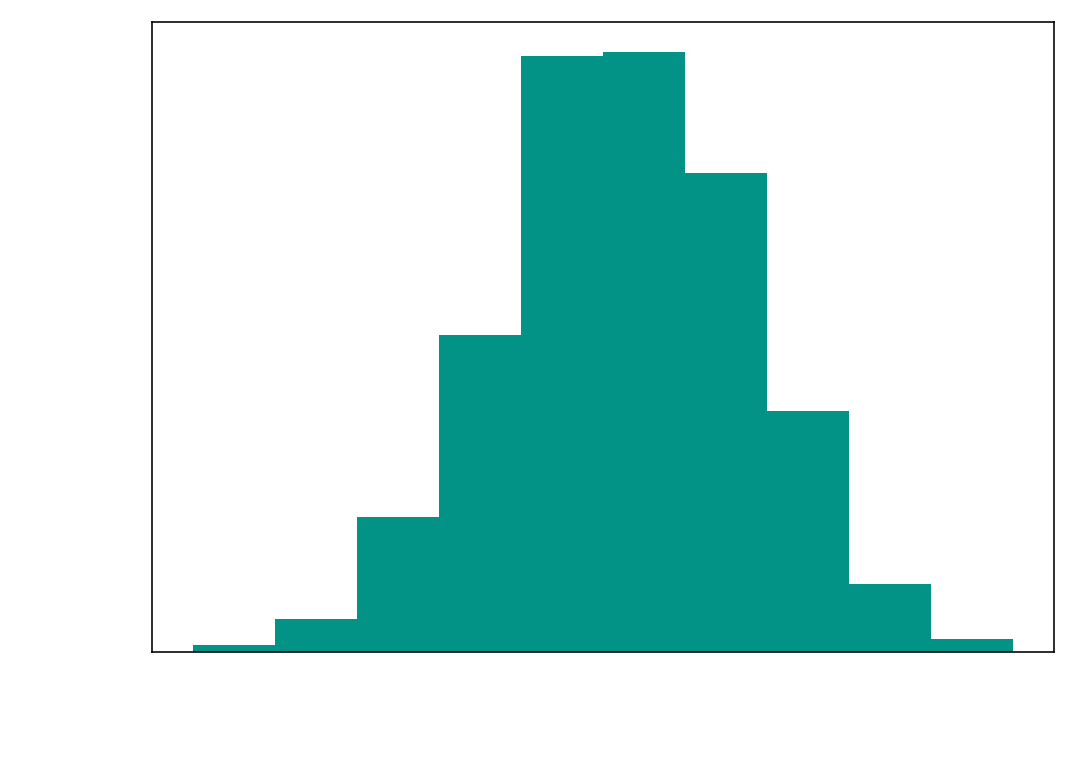

In [10]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

plt.hist(x, color='xkcd:teal')

plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.xlabel(r"Position $x$", fontsize=30, color = 'w')
plt.ylabel(r"Number of Samples", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600

#"""
plt.show()

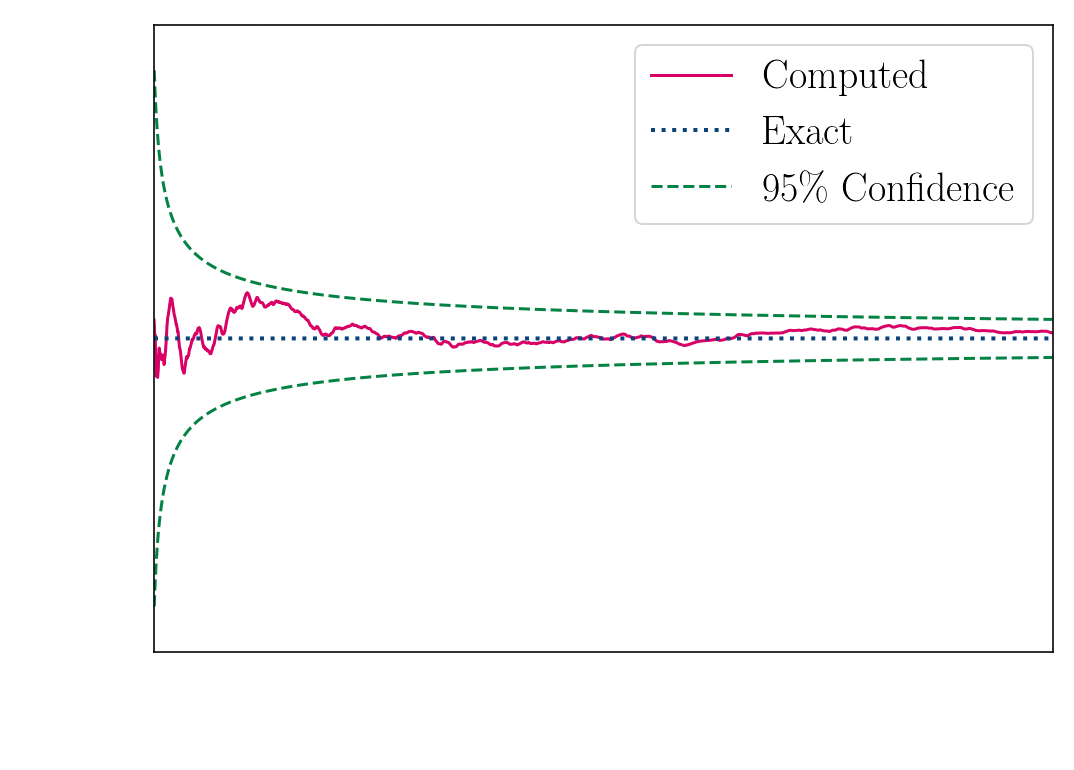

In [11]:
means = np.zeros_like(x)[1:]

Q = np.shape(means)[0]

for k in np.arange(1, Q):
    
    means[k] = np.mean(x[0:k])

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

NN = np.arange(0,Q)

plt.plot(NN, means, linewidth = 1.5, color='xkcd:dark hot pink')
plt.plot(NN, np.zeros(Q), linewidth = 2, color='xkcd:twilight blue', linestyle='dotted')
plt.plot(NN[20:], 2.*sd_guess*NN[20:]**-0.5, linewidth = 1.5, color='xkcd:jungle green', linestyle='dashed')
plt.plot(NN[20:],-2.*sd_guess*NN[20:]**-0.5, linewidth = 1.5, color='xkcd:jungle green', linestyle='dashed')
#np.ones_like(NN)

plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.legend(['Computed', 'Exact', '95$\%$ Confidence'], loc='best', fontsize=20)

plt.xlabel(r"Sample Size", fontsize=30, color = 'w')
plt.ylabel(r"Mean", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.xlim([20, Q])
plt.ylim([-1.5, 1.5])

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600

#"""
plt.show()

Once more, I find we typically get a nice-looking histogram and a solution fitting nicely in the predicted confidence interval. 

Finally, we can put our error estimation heuristic to the test by plotting the mean evolution over a whole family of samples. Below, we run our Markov chain to completion (with automatic batch size selection) $100$ times and plot the evolution of $\langle x\rangle_{n}$ for each realization. We obtain an approximate $\sigma_{\infty}$ by averaging the final $\sigma_{n}$ over all realizations. 

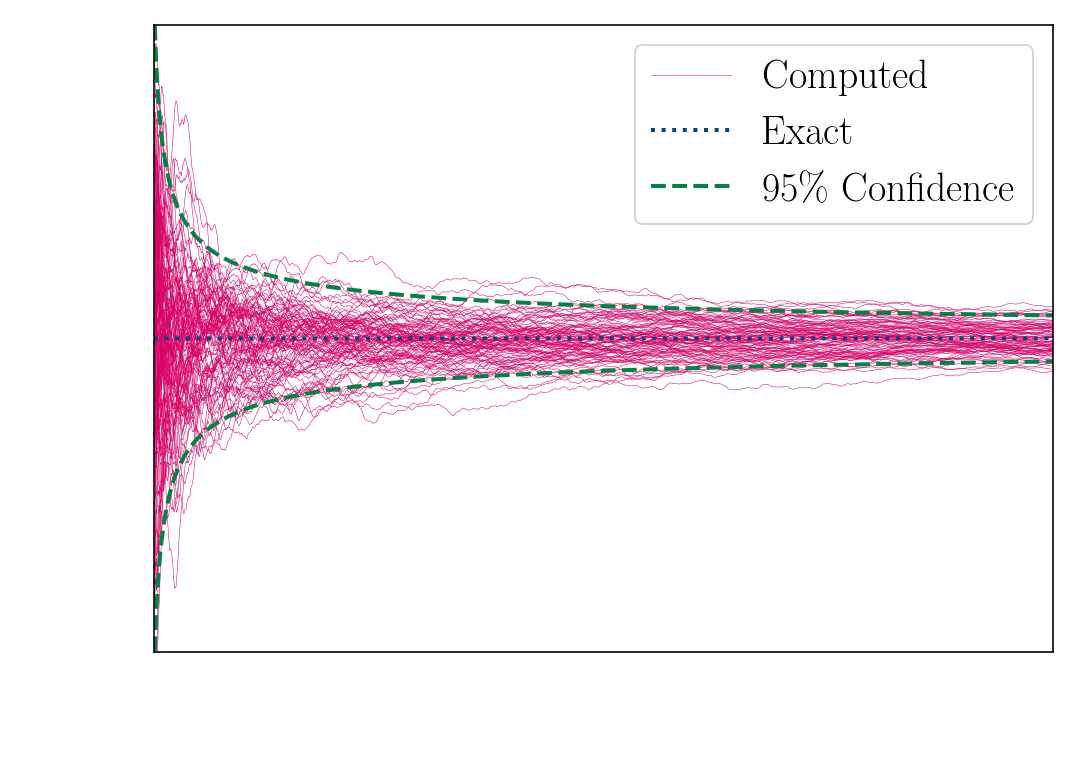

In [12]:
fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

sd_guesses = np.array([])

for m in np.arange(0, 1e2):
    
    x, sd_guess = mh_gaussian_sampling_autobatch(0., params, verbose = False)

    sd_guesses = np.append(sd_guesses,sd_guess)
    
    means = np.zeros_like(x)[1:]

    Q = np.shape(means)[0]

    for k in np.arange(1, Q):
    
        means[k] = np.mean(x[0:k])

    NN = np.arange(0,Q)

    computed, = plt.plot(NN, means, linewidth = 0.25, color='xkcd:dark hot pink')

# plot the actual mean    
exact, = plt.plot(NN, np.zeros(Q), linewidth = 2., color='xkcd:twilight blue', linestyle='dotted')

# plot a theoretical envelope for error
sd = np.mean(sd_guesses)

thry, = plt.plot(NN[20:], 2*sd*(NN[20:]**-0.5), linewidth = 2, color='xkcd:jungle green', linestyle='dashed')
plt.plot(NN[20:],-2*sd*(NN[20:]**-0.5), linewidth = 2, color='xkcd:jungle green', linestyle='dashed')

ax.legend([computed, exact, thry], ['Computed', 'Exact', '$95\%$ Confidence'], loc='best', fontsize=20)

plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
#plt.rcParams['frameon'] = True

plt.xlabel(r"Sample Size", fontsize=30, color = 'w')
plt.ylabel(r"Mean", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.xlim([20, Q])
plt.ylim([-1.5, 1.5])

plt.tight_layout()

fig.set_size_inches(8, 6)

# Uncomment this if you want to save a hi-res figure 
#plt.savefig('batch_trials'+'.png', dpi=800)

#"""
plt.show()

In all my experiments, I have found that the predicted $95\%$ confidence interval fits the data quite nicely. So, our very loose central limit theorem argument appears to have given us a really solid error estimate. 